> 这个文档告诉我们：采样时，使用同轨策略的轨迹进行采样比使用均匀分布采样，可以更快逼近真实价值。

> 当然，也有危险，比如一次又一次地对相同区域更新，显然局部视野。

- 有1000个状态时，每个状态有1、3、10个分支；
- 有10000个状态时，每个状态有1、3、10个分支。

*解释：* 分支即状态间的通路，即当前状态可能转换成某几个状态中的一个：
- 如，状态1可能转换为2,3,4，其有3个分支；
- 状态2只可能转换为状态5，其有1个分支。

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

# 2 actions
ACTIONS = [0, 1]

# each transition has a probability to terminate with 0
TERMINATION_PROB = 0.1

# maximum expected updates
MAX_STEPS = 20000

# epsilon greedy for behavior policy
EPSILON = 0.1

# break tie randomly
def argmax(value):
    max_q = np.max(value)
    return np.random.choice([a for a, q in enumerate(value) if q == max_q])

class Task():
    # @n_states: number of non-terminal states
    # @b: branch
    # Each episode starts with state 0, and state n_states is a terminal state
    """
    作者没有在一个具体的环境中迭代，而是抽象了一个环境：
    - 有 n_states 个状态
    - 每个 状态-动作 转移到下一个状态，这个对应表由 randint 产生
    - reward 也由 N~(0,1) 产生
    - 注意是环境是固定的
    """
    def __init__(self, n_states, b):
        self.n_states = n_states
        self.b = b

        # transition matrix, each state-action pair leads to b possible states
        self.transition = np.random.randint(n_states, size=(n_states, len(ACTIONS), b))

        # it is not clear how to set the reward, I use a unit normal distribution here
        # reward is determined by (s, a, s')
        self.reward = np.random.randn(n_states, len(ACTIONS), b)

    def step(self, state, action):
        if np.random.rand() < TERMINATION_PROB:
            return self.n_states, 0
        next = np.random.randint(self.b)
        return self.transition[state, action, next], self.reward[state, action, next]

# Evaluate the value of the start state for the greedy policy
# derived from @q under the MDP @task
def evaluate_pi(q, task):
    # use Monte Carlo method to estimate the state value
    runs = 1000
    returns = []
    for r in range(runs):
        rewards = 0
        state = 0
        while state < task.n_states:
            action = argmax(q[state])
            state, r = task.step(state, action)
            rewards += r
        returns.append(rewards)
    return np.mean(returns)

# perform expected update from a uniform state-action distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def uniform(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    for step in tqdm(range(MAX_STEPS)):
        """
        值得学习：
        step 是一个 0,..,20000 的自然数列
        想通过 step 遍历 (state, action) 所有可能（均匀采样）
        使用如下两行方法
        """
        state = step // len(ACTIONS) % task.n_states
        action = step % len(ACTIONS)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    """
    zip(*performance) 可以理解为 performance 的转置
    实际上是 c = zip(a, b) 的逆过程，即将 c 解压为 [a, b]
    """
    return zip(*performance)

# perform expected update from an on-policy distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def on_policy(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    state = 0
    for step in tqdm(range(MAX_STEPS)):
        if np.random.rand() < EPSILON:
            action = np.random.choice(ACTIONS)
        else:
            action = argmax(q[state])

        next_state, _ = task.step(state, action)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if next_state == task.n_states:
            """
            如果到达最终状态，从初始状态开始
            即开启新的一幕
            """
            next_state = 0
        state = next_state

        """
        评估初始状态价值
        """
        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance)

100%|████████████████████████████████| 20000/20000 [00:15<00:00, 1333.10it/s]


100%|████████████████████████| 20000/20000 [00:22<00:00, 901.04it/s]


100%|████████████████████████████████| 20000/20000 [00:17<00:00, 1170.15it/s]


100%|████████████████████████████████| 20000/20000 [00:15<00:00, 1330.42it/s]
D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


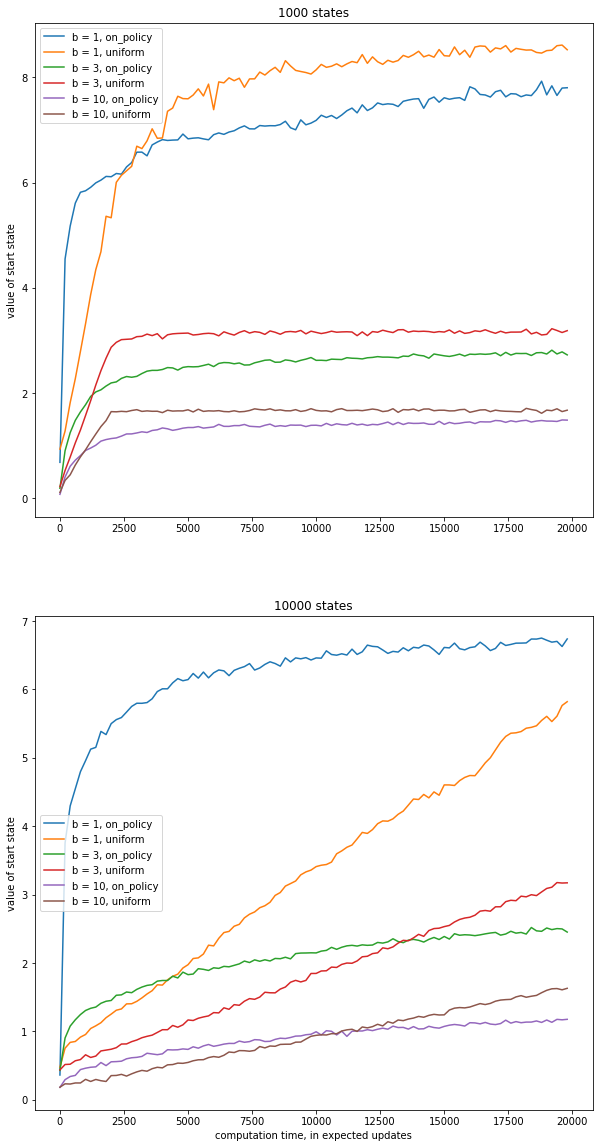

In [2]:
num_states = [1000, 10000]
branch = [1, 3, 10]
methods = [on_policy, uniform]

# average accross 30 tasks
n_tasks =  30

# number of evaluation points
"""
每根曲线有100个结点
即要评估 MAX_STEPS / x_ticks 次初始状态价值
"""
x_ticks = 100

plt.figure(figsize=(10, 20))
for i, n in enumerate(num_states):
    plt.subplot(2, 1, i+1)
    for b in branch:
        tasks = [Task(n, b) for _ in range(n_tasks)]
        for method in methods:
            value = []
            for task in tasks:
                steps, v = method(task, MAX_STEPS / x_ticks)
                value.append(v)
            value = np.mean(np.asarray(value), axis=0)
            plt.plot(steps, value, label='b = %d, %s' % (b, method.__name__))
    plt.title('%d states' % (n))

    plt.ylabel('value of start state')
    plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('computation time, in expected updates')

plt.show()